# Red Wine Quality

This project was developed to create model capable of predicting the quality of a Red Wine based on some features. This project also tries to estipulate the main attributes (features) that are related to the quality.

## Goal
The goal is classify wines into bad or good! If quality is greater than 6 is good.

## Data
The data was provided by Kaggle, available in: https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009

Tha data has the following sctructure:

1. fixed acidity
2. volatile acidity
3. citric acid
4. residual sugar
5. chlorides
6. free sulfur dioxide
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol
12. **quality (target)**

## Understanding the data

The following cells tries to understand the relation between features and the target (quality)

In [1]:
# Importing tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# handle tools
from sklearn.model_selection import train_test_split

# models(estimators)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

# evaluation tools
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

# metrics
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, classification_report

### Seeing the data

In [2]:
# getting the data
df = pd.read_csv("data/winequality-red.csv")
df.sort_values(by=["quality"], inplace=True)
len(df)

1599

### Worst wines

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1478,7.1,0.875,0.05,5.7,0.082,3.0,14.0,0.99808,3.40,0.52,10.2,3
832,10.4,0.440,0.42,1.5,0.145,34.0,48.0,0.99832,3.38,0.86,9.9,3
899,8.3,1.020,0.02,3.4,0.084,6.0,11.0,0.99892,3.48,0.49,11.0,3
1374,6.8,0.815,0.00,1.2,0.267,16.0,29.0,0.99471,3.32,0.51,9.8,3
459,11.6,0.580,0.66,2.2,0.074,10.0,47.0,1.00080,3.25,0.57,9.0,3


### Best wines

In [120]:
df.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
495,10.7,0.35,0.53,2.6,0.070,5.0,16.0,0.99720,3.15,0.65,11.0,8
1403,7.2,0.33,0.33,1.7,0.061,3.0,13.0,0.99600,3.23,1.10,10.0,8
1090,10.0,0.26,0.54,1.9,0.083,42.0,74.0,0.99451,2.98,0.63,11.8,8
1449,7.2,0.38,0.31,2.0,0.056,15.0,29.0,0.99472,3.23,0.76,11.3,8
1549,7.4,0.36,0.30,1.8,0.074,17.0,24.0,0.99419,3.24,0.70,11.4,8


### Potential features related to quality

One features maybe are strongly related to the quality. As it shows, the best wines has **lower** `volatile acidity.

### Checking for missing values and duplicated

In [121]:
df.isna().sum() #fortunately all rows and columns filled

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [4]:
df.duplicated().sum()

240

In [5]:
# dropping all duplicated
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

Tha plot show us that maybe a good fixed acidity is lower than 14

## Getting potential features

Let's see some plots with the potential features that we saw

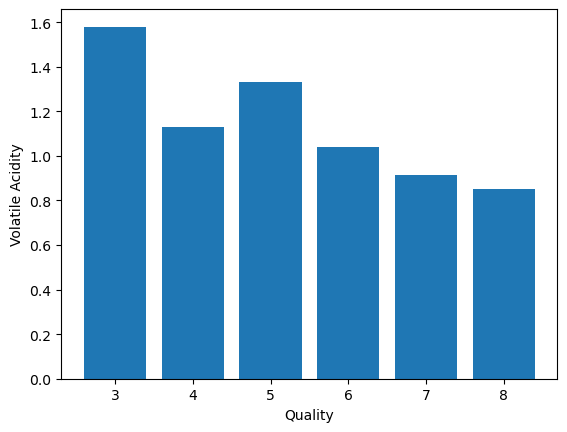

In [15]:
# seeing volatile acidity
fig, ax = plt.subplots()
ax.bar(df["quality"], df["volatile acidity"])
ax.set(xlabel="Quality", ylabel="Volatile Acidity")
plt.show()

We can see a little descendent curve here, but we cannot get any conclusion yet.

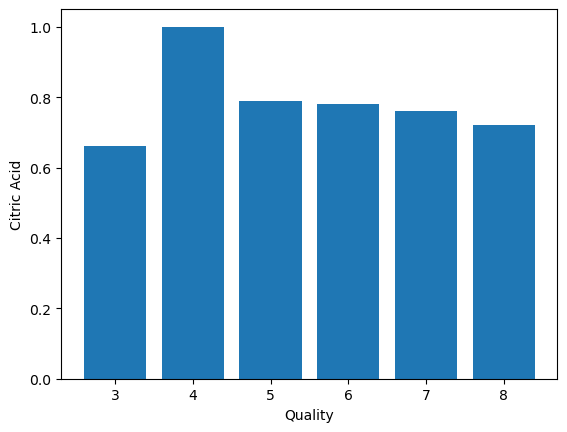

In [17]:
fix, ax = plt.subplots()
ax.bar(df["quality"], df["citric acid"])
ax.set(xlabel="Quality", ylabel="Citric Acid")

plt.show()

## Building the model
The following cells try some models and chooses the best model (apparently)

### Preparing data
Dividing the data between training set and test set

In [18]:
# binarizing the data
df.quality = df.quality > 6
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1478,7.1,0.875,0.05,5.7,0.082,3.0,14.0,0.99808,3.40,0.52,10.2,False
832,10.4,0.440,0.42,1.5,0.145,34.0,48.0,0.99832,3.38,0.86,9.9,False
899,8.3,1.020,0.02,3.4,0.084,6.0,11.0,0.99892,3.48,0.49,11.0,False
1374,6.8,0.815,0.00,1.2,0.267,16.0,29.0,0.99471,3.32,0.51,9.8,False
459,11.6,0.580,0.66,2.2,0.074,10.0,47.0,1.00080,3.25,0.57,9.0,False


In [19]:
# separating features from target
x = df.drop("quality", axis=1)
y = df.quality

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [20]:
np.random.seed(324)
# models dict
models = {
    "rfc": RandomForestClassifier(),
    "knn": KNeighborsClassifier(),
    "svc": SVC(),
    "hist_grad": HistGradientBoostingClassifier(),
}

In [21]:
# setting up results dict (with mean absolute error metric)
results = {}

# training each model
for name, model in models.items():
    model.fit(x_train, y_train)
    y_preds = model.predict(x_test)# rounding predicions
    results[name] = cross_val_score(model, x, y, cv=5).mean()

# showing the results
results

{'rfc': 0.881528109398741,
 'knn': 0.8616507488604297,
 'svc': 0.8660787931408727,
 'hist_grad': 0.8748914695029304}

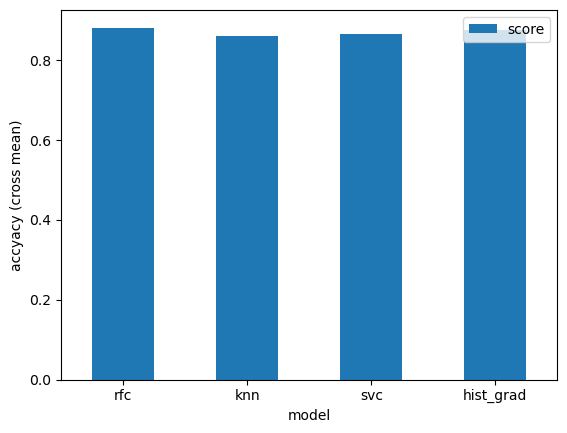

In [22]:
df_results = pd.DataFrame(results, index=["score"])
df_results.T.plot.bar()
plt.xlabel("model")
plt.ylabel("accyacy (cross mean)")
plt.xticks(rotation=False);

The metric used was the `accuracy` and the best score was achieved by the RandomForestClassifier model

In [28]:
### Tunning hyperparameters
rfc_distribs = {
    "n_estimators": [100, 120, 150],
    "max_depth": [None, 2, 4, 8, 16],
    "min_samples_split": [2, 4, 6, 8],
    "max_leaf_nodes": [None, 2, 4, 8, 16],
    "n_jobs": [-1]
}

# making combinations
tuned_model = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=324),
                                      param_distributions=rfc_distribs,
                                      n_iter=50)

# fitting
tuned_model.fit(x_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=324),
                   n_iter=50,
                   param_distributions={'max_depth': [None, 2, 4, 8, 16],
                                        'max_leaf_nodes': [None, 2, 4, 8, 16],
                                        'min_samples_split': [2, 4, 6, 8],
                                        'n_estimators': [100, 120, 150],
                                        'n_jobs': [-1]})

In [29]:
tuned_model.best_params_

{'n_jobs': -1,
 'n_estimators': 120,
 'min_samples_split': 2,
 'max_leaf_nodes': 16,
 'max_depth': 4}

### Using the best params to build the final model

In [30]:
# creating the model
model = RandomForestClassifier(n_jobs=-1,
                               n_estimators=120,
                               min_samples_split=4,
                              max_leaf_nodes=16,
                              max_depth=None,
                              random_state=342)

# training the model
model.fit(x_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, min_samples_split=4, n_estimators=120,
                       n_jobs=-1, random_state=342)

In [31]:
# Making predictions
y_preds = model.predict(x_test)

In [32]:
# seeing the score
cross_val_score(model, x, y, cv=5).mean()

0.881528109398741

Improvement from initial model: 0.8815 -> 0.8815 (no improvement)

this means that the model has `88% of classifying the wine correctly`

### Showing the features importances

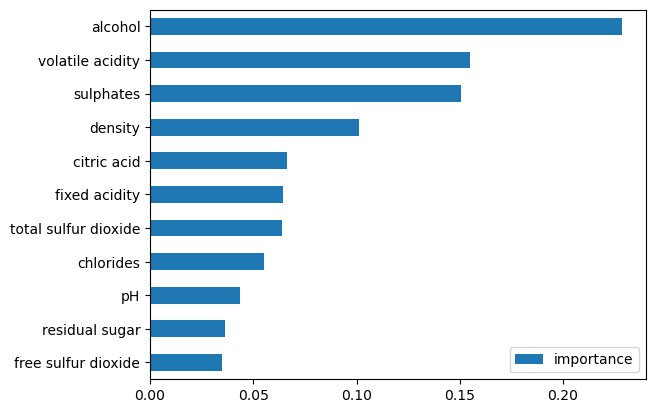

In [33]:
analy_df = pd.DataFrame(model.feature_importances_,
                        index=df.drop("quality", axis=1).columns,
                        columns=["importance"]
                       )
analy_df.sort_values(by=["importance"], inplace=True)
analy_df.plot.barh();

We predicted that the volatile acidity would have some importance in predicting `quality`, and it was right. However the `most importante feature` that the RandomForestClassifier algorithm founded was the alcohol feature.

## Results

### ROC curve and AUC

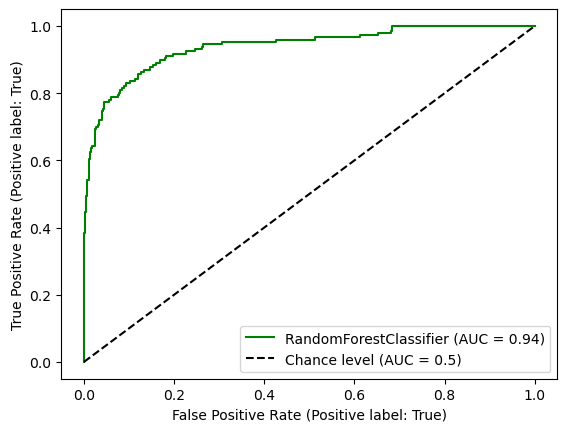

In [38]:
RocCurveDisplay.from_estimator(model,
                               x_train,
                               y_train,
                               plot_chance_level=True,
                               color="green")
plt.show()

### Confusion Matrix

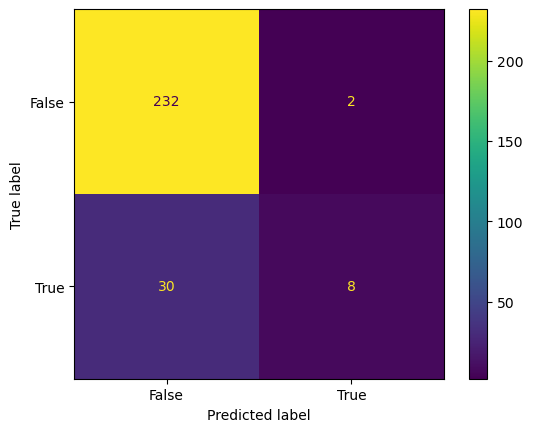

In [34]:
ConfusionMatrixDisplay.from_estimator(model, x_test, y_test);

The mattrix suggets that the model is struggling in classifying true good wines

### Accuracy

`The model has currently about 88% of chance in classyfing corretly the wine`